In [2]:
from pymatgen.core import Structure as p
from pymatgen.io import pwscf
from matplotlib import pyplot as plt
from pymatgen.symmetry.analyzer  import SpacegroupAnalyzer as sym
import numpy as np
from pymatgen.core.units import ArrayWithUnit as conv

def remove_coords(fname="scf.in"):
    with open(fname) as f1:
        lines = f1.readlines()

    with open(fname,"w") as f2:
        f2.writelines(lines[:-4])

In [3]:

s=p.from_file("../structures/relaxed_licoo2_mono.cif")
pseudo={"Li":"Li.pbe-s-kjpaw_psl.1.0.0.UPF",
        "Co":"Co.pbe-n-kjpaw_psl.1.0.0.UPF",
        "O":"O.pbe-n-kjpaw_psl.1.0.0.UPF"}
control={'pseudo_dir' : '/home/srr70/QE/pseudo/pslibrary.1.0.0/pbe/PSEUDOPOTENTIALS/',
        'verbosity' :'high',
         'prefix':'lco',
        'calculation': 'scf',
         'restart_mode':'from_scratch',
         'wf_collect':True,
        'outdir': './',
        'tprnfor':True,
        'tstress':True}
system={"ecutwfc":120.0 ,
        "ecutrho" : 480.0,
        "occupations":'smearing',
        "smearing":'mp',
        "degauss":0.02,
       "assume_isolated":'2D'}
electrons={"diagonalization":'david'}
pw=pwscf.PWInput(s,pseudo=pseudo,
                 control=control,
                 kpoints_grid=(8,8,1),
                 electrons=electrons,
                system=system)
pw.write_file("scf.in")

/Users/santy/miniconda3/lib/python3.8/site-packages/pymatgen/io/cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [24]:
#mpirun -np 24 /home/srr70/install/qe_6.6/q-e-qe-6.6/bin/pw.x -npool 24 -in scf.in |tee scf.out
#mpirun -np 24 /home/srr70/install/qe_6.6/q-e-qe-6.6/bin/ph.x -npool 24 -in ph.in |tee ph.out

# QE phonons

In [130]:
###---- for first scf
prefix="lco"
s=p.from_file("../structures/lco_gpw_relax.cif")
s.replace()
pseudo={"Li":"Li.pbe-s-kjpaw_psl.1.0.0.UPF",
        "Co":"Co.pbe-n-kjpaw_psl.1.0.0.UPF",
        "O":"O.pbe-n-kjpaw_psl.1.0.0.UPF"}
control={'pseudo_dir' : '/home/srr70/QE/pseudo/pslibrary.1.0.0/pbe/PSEUDOPOTENTIALS/',
        'verbosity' :'high',
         'prefix':prefix,
        'calculation': 'scf',
         'restart_mode':'from_scratch',
        'outdir': './',
        }
system={"ecutwfc":120.0 ,
        "ecutrho" : 480.0,
        "occupations":'smearing',
        "smearing":'mp',
        "degauss":0.02,
        "la2F":True}
electrons={"diagonalization":'david'}
pw=pwscf.PWInput(s,pseudo=pseudo,
                 control=control,
                 kpoints_grid=(18,18,1),
                 electrons=electrons,
                system=system)
pw.write_file("scf_fit.in")

/Users/santy/miniconda3/lib/python3.8/site-packages/pymatgen/io/cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [22]:
# for second scf
prefix="lco"
s1=p.from_file("../structures/lco_gpw_relax.cif")
s1.replace_species({"Li":"Na"})
s=sym(s1).get_symmetrized_structure()
pseudo={"Na":"Na.pbe-spn-kjpaw_psl.1.0.0.UPF",
        "Co":"Co.pbe-n-kjpaw_psl.1.0.0.UPF",
        "O":"O.pbe-n-kjpaw_psl.1.0.0.UPF"}
control={'pseudo_dir' : '/home/srr70/QE/pseudo/pslibrary.1.0.0/pbe/PSEUDOPOTENTIALS/',
        'verbosity' :'high',
         'prefix':prefix,
        'calculation': 'scf',
         'restart_mode':'from_scratch',
        'outdir': './',
        'wf_collect':True,
        }
system={"ecutwfc":120.0 ,
        "ecutrho" : 480.0,
        "occupations":'smearing',
        "smearing":'mp',
        "degauss":0.02,
        "ibrav":4,
        "celldm(1)":conv(s1.lattice.abc,"ang").to("bohr")[0],
        "celldm(3)":conv(s1.lattice.abc,"ang").to("bohr")[2]/conv(s1.lattice.abc,"ang").to("bohr")[0],
       }
electrons={"diagonalization":'david'}
pw=pwscf.PWInput(s,pseudo=pseudo,
                 control=control,
                 kpoints_grid=(12,12,1),
                 electrons=electrons,
                system=system)
pw.write_file("scf.in")
remove_coords(fname="scf.in")
!open scf.in

In [58]:
prefix="'lco'"
inputs=f"""&inputph
   tr2_ph=1.0d-12,
   prefix={prefix},
   fildvscf='pbdv', 
   outdir='./',
   fildyn='pb.dyn', 
   electron_phonon='interpolated', 
   el_ph_sigma=0.005, 
   el_ph_nsigma=10,
   trans=.true., 
   ldisp=.true.,
   nq1=4, 
   nq2=4, 
   nq3=1,
   search_sym=.FALSE.,
   recover=.true.,
/"""
with open("elph.in", "w") as text_file:
    print(inputs, file=text_file)

In [114]:
from pymatgen.io.ase import AseAtomsAdaptor as a
a1=["{:3f} {:3f} {:3f} 0".format(i[0],i[1],i[2]) for i in a().get_atoms(s1).cell.bandpath("GKMG").interpolate(npoints=30).kpts]
for i in a1:print(i)

0.000000 0.000000 0.000000 0
0.027778 0.027778 0.000000 0
0.055556 0.055556 0.000000 0
0.083333 0.083333 0.000000 0
0.111111 0.111111 0.000000 0
0.138889 0.138889 0.000000 0
0.166667 0.166667 0.000000 0
0.194444 0.194444 0.000000 0
0.222222 0.222222 0.000000 0
0.250000 0.250000 0.000000 0
0.277778 0.277778 0.000000 0
0.305556 0.305556 0.000000 0
0.333333 0.333333 0.000000 0
0.361111 0.277778 0.000000 0
0.388889 0.222222 0.000000 0
0.416667 0.166667 0.000000 0
0.444444 0.111111 0.000000 0
0.472222 0.055556 0.000000 0
0.500000 0.000000 0.000000 0
0.454545 0.000000 0.000000 0
0.409091 0.000000 0.000000 0
0.363636 0.000000 0.000000 0
0.318182 0.000000 0.000000 0
0.272727 0.000000 0.000000 0
0.227273 0.000000 0.000000 0
0.181818 0.000000 0.000000 0
0.136364 0.000000 0.000000 0
0.090909 0.000000 0.000000 0
0.045455 0.000000 0.000000 0
0.000000 0.000000 0.000000 0


In [99]:
fname="data/Al444.freq"
with open(fname) as f1:
        lines = f1.readlines()
lines=[i.split() for i in lines]

In [110]:
data=np.array([i for i in lines[1:] if len(i)>3],dtype=float).flatten().reshape(-1,12)

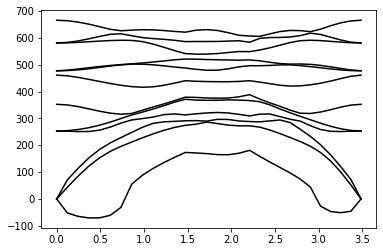

In [120]:
x=a().get_atoms(s1).cell.bandpath("GKMG").interpolate(npoints=30).get_linear_kpoint_axis()[0]
for i in data.T:
    plt.plot(x,i,c="k")

In [129]:
fname="data/elph.gamma.10"
with open(fname) as f1:
        lines = f1.readlines()
lines=[i.split() for i in lines]
lines[:5]

[['&plot', 'nbnd=', '12,', 'nks=', '30', '/'],
 ['0.000000', '0.000000', '0.000000'],
 ['-0.0000', '-0.0000', '-0.0000-2782.5595-2782.5595-3006.0480'],
 ['-1399.8905-1803.0384-1803.0384-1200.7215-1200.7215-1231.6730'],
 ['0.027778', '0.027778', '0.000000']]

In [11]:
###---- for first scf
prefix="lco"
s=p.from_file("../structures/lco_gpw_relax.cif")

/Users/santy/miniconda3/lib/python3.8/site-packages/pymatgen/io/cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [15]:
s

Structure Summary
Lattice
    abc : 2.8429 2.8429 15.0
 angles : 90.0 90.0 119.99999999999999
 volume : 104.9893042573283
      A : 2.8429 0.0 1.7407741926480053e-16
      B : -1.4214499999999994 2.462023620418781 1.7407741926480053e-16
      C : 0.0 0.0 15.0
PeriodicSite: Na (0.0000, 1.6413, 4.7079) [0.3333, 0.6667, 0.3139]
PeriodicSite: Co (1.4215, 0.8206, 2.6883) [0.6667, 0.3333, 0.1792]
PeriodicSite: O (0.0000, 1.6413, 1.7702) [0.3333, 0.6667, 0.1180]
PeriodicSite: O (2.8429, 0.0000, 3.9430) [1.0000, 0.0000, 0.2629]